In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.stats import entropy

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import classification_report, confusion_matrix 

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch

np.random.seed(42)
torch.manual_seed(42)

In [4]:
all_Chinese = pd.read_excel('/Users/anyingbai/Desktop/连续剧/Oxford/COPD模型/最新修改/心血管共病/机器学习模型训练/CHARLS_10_18基线无共病.xlsx', index_col=0)
Chinese2=all_Chinese.copy(deep=True)
Chinese2.dropna(axis=0, how='any', subset=None, inplace=True)
Chinese2.head()
Chinese2.isnull().sum()
Chinese2_Y = Chinese2['Cardiometabolic_multi_18']
Chinese2_X = Chinese2.loc[:,['ADL_Disability','IADL_Disability','edu_group','Male','Married','age','household_wealth','Excessive_drink','physical_activity','smoking_present']]
X_train, X_test, y_train, y_test = train_test_split(Chinese2_X, Chinese2_Y, test_size = 0.40, random_state=42)
# 定义训练数据加载器
# 可以使用PyTorch的DataLoader来批量加载训练数据

from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import softmax

batch_size = 64
train_dataset = TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values))  # Ensure y_train has shape (batch_size, 1)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 使用训练集的均值和标准差对测试集进行标准化
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)

# 设置模型结构和参数
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # 在这里定义模型结构，使用给定的最佳参数配置
        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 1), ##改为1，输出变成1维
            nn.Sigmoid()  # 在输出层使用 Sigmoid 激活函数
        )

    def forward(self, x):
        x = self.fc(x)
        return x

# 创建模型实例
torch.manual_seed(42)
model = MLP().float()

# 定义优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.functional.binary_cross_entropy # 使用functional中的binary_cross_entropy
# 设置训练的总轮次（epochs）
num_epochs = 100

# 定义训练和测试函数
def train(model, optimizer, criterion, train_loader):
    model.train()
    train_losses = []
    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        batch_data = batch_data.float()
        outputs = model(batch_data)
        loss = criterion(outputs.squeeze(), batch_labels.float())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return np.mean(train_losses)

def test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        val_outputs = model(torch.Tensor(X_test_scaled))
        #print("Raw Model Outputs:")
        #print(val_outputs.squeeze().cpu().numpy())
        val_loss = criterion(val_outputs.squeeze(), torch.Tensor(y_test.values).float())


        # 计算预测值-改为输出一个值，大于0.5=1，小于0.5=0
        predicted = (val_outputs > 0.5).float()

        # 打印预测值
        #print("Predicted Values:")
        #print(predicted.cpu().numpy().squeeze())
        
        # 计算熵值
        probabilities = torch.nn.functional.sigmoid(val_outputs)
        epsilon = 1e-8  # 小的常数值
        probabilities = probabilities + epsilon
        entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
        
        # 计算平均熵值
        average_entropy = torch.mean(entropy).item()
        
        # 计算评估指标
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
        
        # 对于二分类问题，需要使用模型输出的概率值来计算 AUPRC 和 AUROC
        # 获取模型预测的概率值
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        positive_probabilities = torch.nn.functional.sigmoid(val_outputs).cpu().numpy()  # 正类的概率
        
        # 计算 AUPRC 和 AUROC
        auprc = average_precision_score(y_test, positive_probabilities)
        auroc = roc_auc_score(y_test, positive_probabilities)
        
        return val_loss.item(), precision, recall, f1, auprc, auroc, average_entropy

# 在每个 epoch 中更新测试函数的调用并存储评估指标
test_metrics = {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auprc': [], 'auroc': [], 'entropy': []}
train_losses = []
test_losses = []
accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    test_loss, precision, recall, f1, auprc, auroc, avg_entropy = test(model, X_test_scaled, y_test)  
    # Calculate accuracy
    with torch.no_grad():
        val_outputs = model(torch.Tensor(X_test_scaled))
        predicted = (val_outputs > 0.5).float()
    # Ensure y_test is a NumPy array for accurate comparison
    y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

    accuracy = (predicted.cpu().numpy().squeeze() == y_test_array).mean()

    # Append values to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    # 存储评估指标
    test_metrics['loss'].append(test_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)
    
# 输出最终评估指标
final_metrics = {
    'Average_Test_Loss': np.mean(test_metrics['loss']),
    'Average_Precision': np.mean(test_metrics['precision']),
    'Average_Recall': np.mean(test_metrics['recall']),
    'Average_F1': np.mean(test_metrics['f1']),
    'Average_AUPRC': np.mean(test_metrics['auprc']),
    'Average_AUROC': np.mean(test_metrics['auroc']),
    'Average_entropy': np.mean(test_metrics['entropy'])
    
}
print("Final Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

Final Evaluation Metrics:
Average_Test_Loss: 0.6776543402671814
Average_Precision: 0.169663608342647
Average_Recall: 0.43755980861244026
Average_F1: 0.24291711185271897
Average_AUPRC: 0.1818493472567943
Average_AUROC: 0.5678921962580227
Average_entropy: 0.42741097390651706


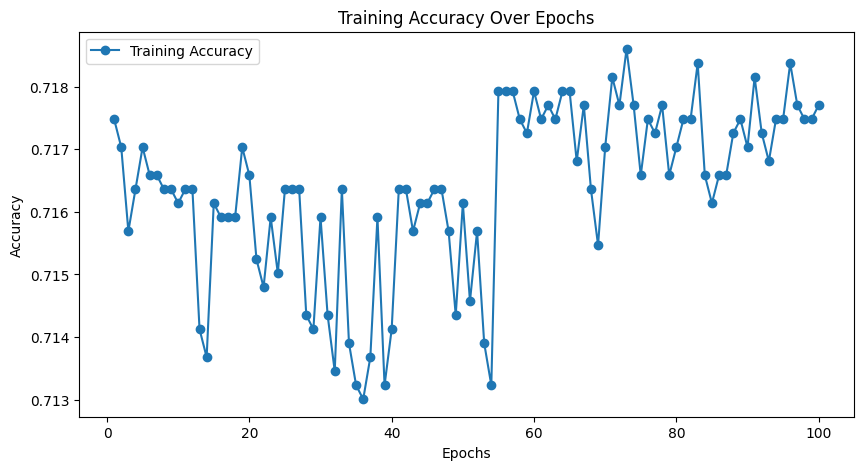

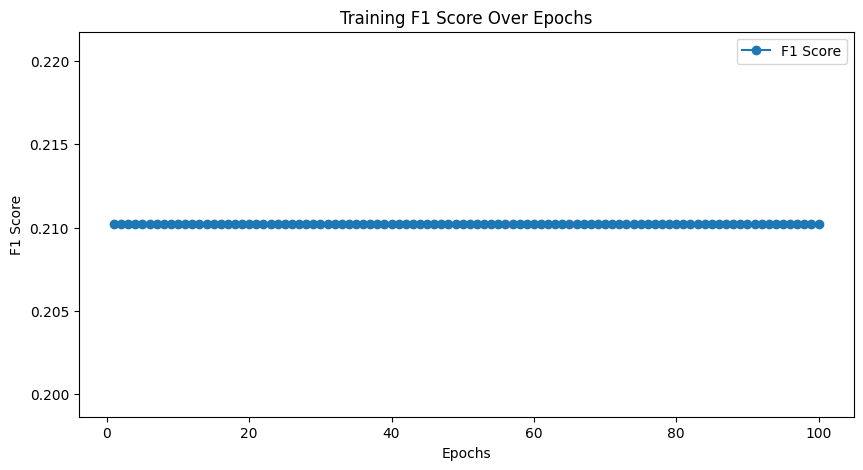

In [10]:
# Lists to store training metrics for each epoch
train_losses = []
train_accuracies = []  # Added for storing training accuracies
f1_scores = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)

    # Calculate accuracy on training data
    model.eval()
    with torch.no_grad():
        train_outputs = model(torch.Tensor(X_train_scaled))
        train_predicted = (train_outputs > 0.5).float()

    # Ensure y_train is a NumPy array for accurate comparison
    y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train

    train_accuracy = (train_predicted.cpu().numpy().squeeze() == y_train_array).mean()
    train_accuracies.append(train_accuracy)

    # Append values to lists
    train_losses.append(train_loss)
    f1_scores.append(f1)

    # 存储评估指标
    test_metrics['loss'].append(train_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)

# Plot learning curves
epochs = range(1, num_epochs + 1)

# Plotting Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, label='F1 Score', marker='o')
plt.title('Training F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# ... (Remaining code remains unchanged)

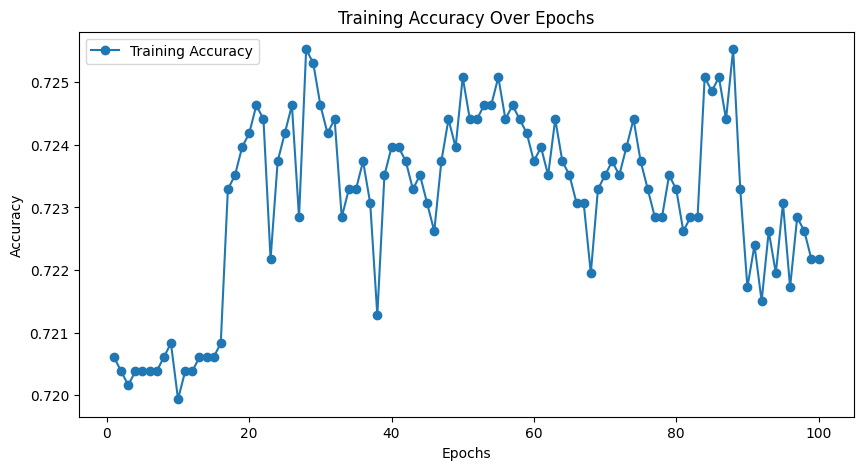

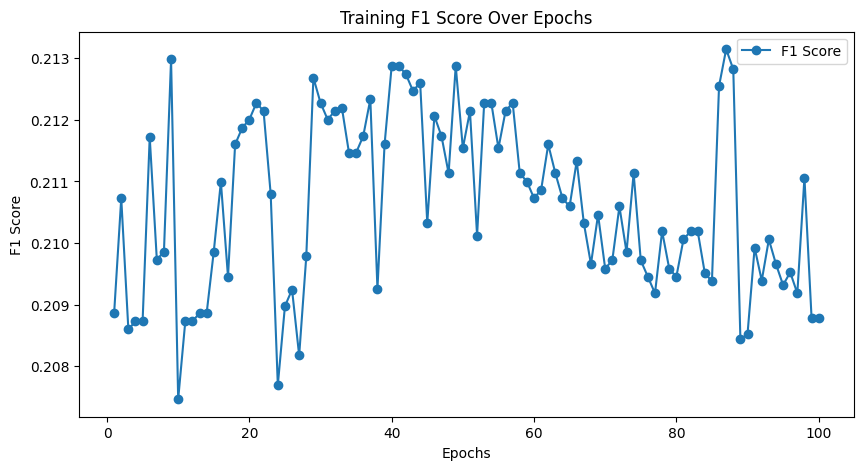

In [12]:
# Lists to store training metrics for each epoch
train_losses = []
train_accuracies = []  # Added for storing training accuracies
f1_scores = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)

    # Calculate accuracy on training data
    model.eval()
    with torch.no_grad():
        train_outputs = model(torch.Tensor(X_train_scaled))
        train_predicted = (train_outputs > 0.5).float()

    # Ensure y_train is a NumPy array for accurate comparison
    y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train

    # Calculate F1 score
    f1 = f1_score(y_train_array, train_predicted.cpu().numpy().squeeze())
    f1_scores.append(f1)  # Update f1_scores with the correct variable

    # Print F1 score for each epoch
    #print(f"Epoch {epoch + 1}, F1 Score: {f1}")

    # Calculate accuracy on training data
    train_accuracy = (train_predicted.cpu().numpy().squeeze() == y_train_array).mean()
    train_accuracies.append(train_accuracy)

    # Append values to lists
    train_losses.append(train_loss)

    # 存储评估指标
    test_metrics['loss'].append(train_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)

# Plot learning curves
epochs = range(1, num_epochs + 1)

# Plotting Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, label='F1 Score', marker='o')
plt.title('Training F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# ... (Remaining code remains unchanged)


In [14]:
# Lists to store training metrics for each epoch
train_losses = []
train_accuracies = []  # Added for storing training accuracies
f1_scores = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)

    # Calculate accuracy on training data
    model.eval()
    with torch.no_grad():
        train_outputs = model(torch.Tensor(X_train_scaled))
        train_predicted = (train_outputs > 0.5).float()

    # Ensure y_train is a NumPy array for accurate comparison
    y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train

    # Calculate F1 score
    f1 = f1_score(y_train_array, train_predicted.cpu().numpy().squeeze())
    f1_scores.append(f1)  # Update f1_scores with the correct variable

    # Calculate accuracy on training data
    train_accuracy = (train_predicted.cpu().numpy().squeeze() == y_train_array).mean()
    train_accuracies.append(train_accuracy)

    # Append values to lists
    train_losses.append(train_loss)

    # Print metrics for each epoch
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, F1 Score: {f1:.4f}")

    # 存储评估指标
    test_metrics['loss'].append(train_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)

Epoch 1, Train Loss: 4.9673, Train Accuracy: 0.7246, F1 Score: 0.2113
Epoch 2, Train Loss: 4.1789, Train Accuracy: 0.7260, F1 Score: 0.2101
Epoch 3, Train Loss: 4.3129, Train Accuracy: 0.7255, F1 Score: 0.2118
Epoch 4, Train Loss: 4.0037, Train Accuracy: 0.7233, F1 Score: 0.2105
Epoch 5, Train Loss: 4.4805, Train Accuracy: 0.7237, F1 Score: 0.2107
Epoch 6, Train Loss: 5.2573, Train Accuracy: 0.7253, F1 Score: 0.2117
Epoch 7, Train Loss: 4.7762, Train Accuracy: 0.7264, F1 Score: 0.2103
Epoch 8, Train Loss: 5.9246, Train Accuracy: 0.7260, F1 Score: 0.2101
Epoch 9, Train Loss: 4.3173, Train Accuracy: 0.7298, F1 Score: 0.2093
Epoch 10, Train Loss: 2.5895, Train Accuracy: 0.7287, F1 Score: 0.2086
Epoch 11, Train Loss: 2.3951, Train Accuracy: 0.7269, F1 Score: 0.2106
Epoch 12, Train Loss: 2.1374, Train Accuracy: 0.7271, F1 Score: 0.2107
Epoch 13, Train Loss: 1.5336, Train Accuracy: 0.7271, F1 Score: 0.2097
Epoch 14, Train Loss: 0.9029, Train Accuracy: 0.7293, F1 Score: 0.2080
Epoch 15, Train

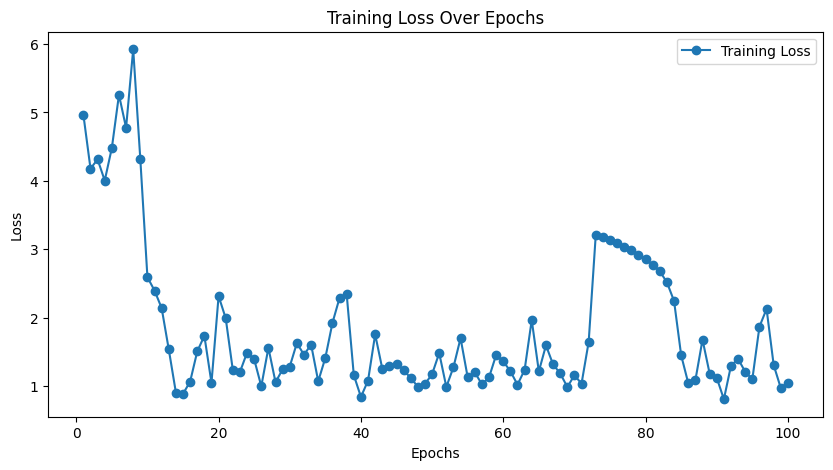

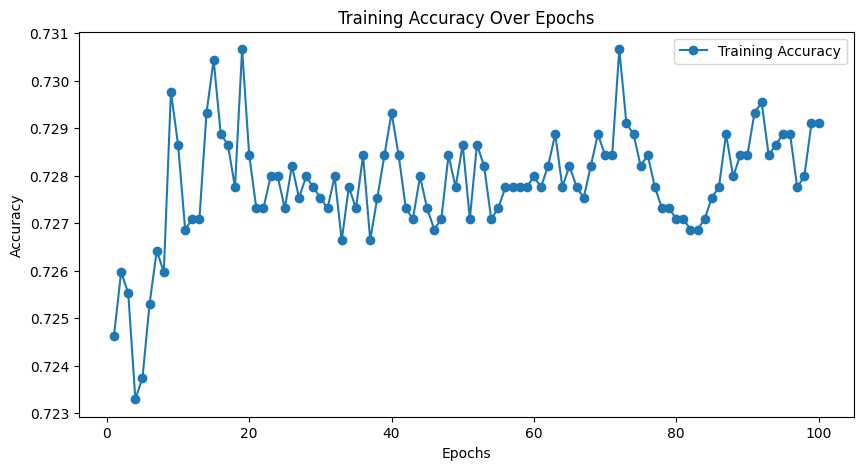

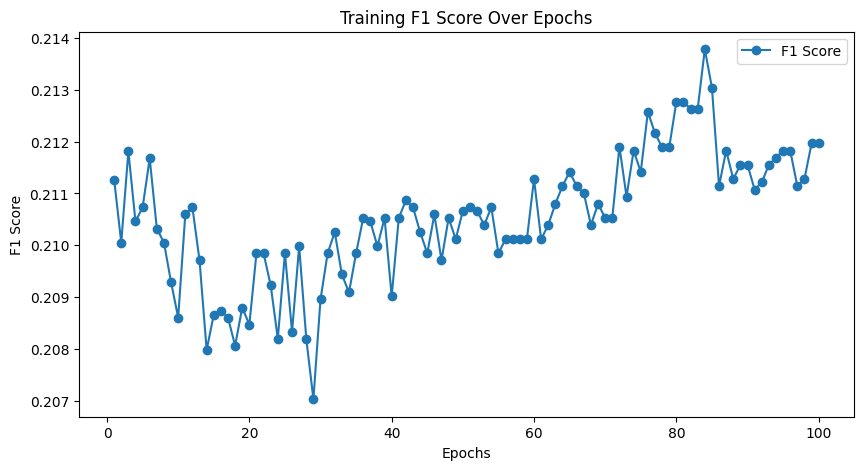

In [15]:
# Plot learning curves
epochs = range(1, num_epochs + 1)

# Plotting Training Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, label='F1 Score', marker='o')
plt.title('Training F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# ... (Remaining code remains unchanged)


In [6]:
# Inside the training loop
with torch.no_grad():
    train_outputs = model(torch.Tensor(X_train_scaled))
    train_predicted = (train_outputs > 0.5).float()

# Ensure y_train is a NumPy array for accurate comparison
y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train

# Calculate F1 score
f1 = f1_score(y_train_array, train_predicted.cpu().numpy().squeeze())

# Print or visualize F1 score
print(f"F1 Score: {f1}")

F1 Score: 0.2135102533172497


In [7]:
# Lists to store training metrics for each epoch
train_losses = []
train_accuracies = []  # Added for storing training accuracies
f1_scores = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)

    # Calculate accuracy on training data
    model.eval()
    with torch.no_grad():
        train_outputs = model(torch.Tensor(X_train_scaled))
        train_predicted = (train_outputs > 0.5).float()

    # Ensure y_train is a NumPy array for accurate comparison
    y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train

    # Calculate F1 score
    f1 = f1_score(y_train_array, train_predicted.cpu().numpy().squeeze())
    f1_scores.append(f1)

    # Print F1 score for each epoch
    print(f"Epoch {epoch + 1}, F1 Score: {f1}")

    # Append values to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 存储评估指标
    test_metrics['loss'].append(train_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)

# ... (Rest of your code remains unchanged)


Epoch 1, F1 Score: 0.21299638989169672
Epoch 2, F1 Score: 0.21122510561255284
Epoch 3, F1 Score: 0.21330137807070104
Epoch 4, F1 Score: 0.21376811594202896
Epoch 5, F1 Score: 0.21608643457382953
Epoch 6, F1 Score: 0.21556886227544908
Epoch 7, F1 Score: 0.2136391068195534
Epoch 8, F1 Score: 0.21338155515370702
Epoch 9, F1 Score: 0.21312462372065022
Epoch 10, F1 Score: 0.21299638989169672
Epoch 11, F1 Score: 0.2136391068195534
Epoch 12, F1 Score: 0.2139423076923077
Epoch 13, F1 Score: 0.21286831028262176
Epoch 14, F1 Score: 0.21299638989169672
Epoch 15, F1 Score: 0.21312462372065022
Epoch 16, F1 Score: 0.2121760096443641
Epoch 17, F1 Score: 0.21134328358208956
Epoch 18, F1 Score: 0.2116527942925089
Epoch 19, F1 Score: 0.2116527942925089
Epoch 20, F1 Score: 0.21096543504171633
Epoch 21, F1 Score: 0.21134328358208956
Epoch 22, F1 Score: 0.21166566446181598
Epoch 23, F1 Score: 0.2126888217522659
Epoch 24, F1 Score: 0.21281741233373638
Epoch 25, F1 Score: 0.2117362371445856
Epoch 26, F1 Scor

In [5]:
#统计测试集里阳性和阴性比例
num_positive_test = sum(y_test == 1)
num_negative_test = sum(y_test == 0)
positive_negative_ratio_test = num_positive_test / num_negative_test
print(f"内部测试集中阳性样本数量：{num_positive_test}")
print(f"内部测试集中阴性样本数量：{num_negative_test}")
print(f"内部测试集中阳性样本与阴性样本的比例：{positive_negative_ratio_test:.2f}")

内部测试集中阳性样本数量：418
内部测试集中阴性样本数量：2566
内部测试集中阳性样本与阴性样本的比例：0.16


In [6]:
#引入欧洲数据作外部验证
all_Europe = pd.read_excel('/Users/anyingbai/Desktop/连续剧/Oxford/COPD模型/最新修改/心血管共病/机器学习模型训练/SHARE_10_18基线无共病.xlsx', index_col=0)
Europe2=all_Europe.copy(deep=True)
Europe2.dropna(axis=0, how='any', subset=None, inplace=True)
Europe2.head()
Europe2_Y = Europe2['Cardiometabolic_multi_18']
Europe2_X = Europe2.loc[:,['ADL_Disability','IADL_Disability','edu_group','Male','Married','age','household_wealth','Excessive_drink','physical_activity','smoking_present']]


# 使用训练集的均值和标准差对测试集进行标准化
scaler = StandardScaler()
Europe2_X_scaled = scaler.fit_transform(Europe2_X)


def test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(42)
        val_outputs = model(torch.Tensor(Europe2_X_scaled))
        val_loss = criterion(val_outputs.squeeze(), torch.Tensor(Europe2_Y.values).float())



        # 计算预测值-改为输出一个值，大于0.5=1，小于0.5=0
        predicted = (val_outputs > 0.5).float()
        
        # 计算熵值
        probabilities = torch.nn.functional.sigmoid(val_outputs)
        epsilon = 1e-8  # 小的常数值
        probabilities = probabilities + epsilon
        entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
        
        
        # 计算平均熵值
        average_entropy = torch.mean(entropy).item()
        
        # 计算评估指标
        precision = precision_score(Europe2_Y, predicted)
        recall = recall_score(Europe2_Y, predicted)
        f1 = f1_score(Europe2_Y, predicted)
        
        # 对于二分类问题，需要使用模型输出的概率值来计算 AUPRC 和 AUROC
        # 获取模型预测的概率值
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        positive_probabilities = torch.nn.functional.sigmoid(val_outputs).cpu().numpy()  # 正类的概率
        
        # 计算 AUPRC 和 AUROC
        auprc = average_precision_score(Europe2_Y, positive_probabilities)
        auroc = roc_auc_score(Europe2_Y, positive_probabilities)
        
        return val_loss.item(), precision, recall, f1, auprc, auroc, average_entropy

# 在每个 epoch 中更新测试函数的调用并存储评估指标
test_metrics = {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auprc': [], 'auroc': [], 'entropy': []}
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    test_loss, precision, recall, f1, auprc, auroc, avg_entropy = test(model, Europe2_X_scaled, Europe2_Y)  
    # Calculate accuracy
    with torch.no_grad():
        val_outputs = model(torch.Tensor(Europe2_X_scaled))
        predicted = (val_outputs > 0.5).float()
    # Ensure y_test is a NumPy array for accurate comparison
    Europe2_Y_array = Europe2_Y.values if isinstance(Europe2_Y, pd.Series) else Europe2_Y

    accuracy = (predicted.cpu().numpy().squeeze() == Europe2_Y_array).mean()

    # Append values to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    # 存储评估指标
    test_metrics['loss'].append(test_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)
    
# 输出最终评估指标
final_metrics = {
    'Average_Test_Loss': np.mean(test_metrics['loss']),
    'Average_Precision': np.mean(test_metrics['precision']),
    'Average_Recall': np.mean(test_metrics['recall']),
    'Average_F1': np.mean(test_metrics['f1']),
    'Average_AUPRC': np.mean(test_metrics['auprc']),
    'Average_AUROC': np.mean(test_metrics['auroc']),
    'Average_entropy': np.mean(test_metrics['entropy'])
    
}
print("Final Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

Final Evaluation Metrics:
Average_Test_Loss: 0.6537570863962173
Average_Precision: 0.19233772191516277
Average_Recall: 0.3220359281437126
Average_F1: 0.2406931233322615
Average_AUPRC: 0.16940920831582215
Average_AUROC: 0.5594054720551985
Average_entropy: 0.43172271460294726


In [8]:
#统计测试集里阳性和阴性比例
num_positive_test = sum(Europe2_Y == 1)
num_negative_test = sum(Europe2_Y == 0)
positive_negative_ratio_test = num_positive_test / num_negative_test
print(f"内部测试集中阳性样本数量：{num_positive_test}")
print(f"内部测试集中阴性样本数量：{num_negative_test}")
print(f"内部测试集中阳性样本与阴性样本的比例：{positive_negative_ratio_test:.2f}")

内部测试集中阳性样本数量：1336
内部测试集中阴性样本数量：8682
内部测试集中阳性样本与阴性样本的比例：0.15


In [9]:
#引入美国数据作外部验证
all_US = pd.read_excel('/Users/anyingbai/Desktop/连续剧/Oxford/COPD模型/最新修改/心血管共病/机器学习模型训练/HRS_10_18基线无共病.xlsx', index_col=0)
US2=all_US.copy(deep=True)
US2.dropna(axis=0, how='any', subset=None, inplace=True)
US2.head()

US2_Y = US2['Cardiometabolic_multi_18']
US2_X = US2.loc[:,['ADL_Disability','IADL_Disability','edu_group','Male','Married','age','household_wealth','Excessive_drink','physical_activity','smoking_present']]

# 使用训练集的均值和标准差对测试集进行标准化
scaler = StandardScaler()
US2_X_scaled = scaler.fit_transform(US2_X)


def test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(42)
        val_outputs = model(torch.Tensor(US2_X_scaled))
        val_loss = criterion(val_outputs.squeeze(), torch.Tensor(US2_Y.values).float())



        # 计算预测值-改为输出一个值，大于0.5=1，小于0.5=0
        predicted = (val_outputs > 0.5).float()
        
        # 计算熵值
        probabilities = torch.nn.functional.sigmoid(val_outputs)
        epsilon = 1e-8  # 小的常数值
        probabilities = probabilities + epsilon
        entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
        
        
        # 计算平均熵值
        average_entropy = torch.mean(entropy).item()
        
        # 计算评估指标
        precision = precision_score(US2_Y, predicted)
        recall = recall_score(US2_Y, predicted)
        f1 = f1_score(US2_Y, predicted)
        
        # 对于二分类问题，需要使用模型输出的概率值来计算 AUPRC 和 AUROC
        # 获取模型预测的概率值
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        positive_probabilities = torch.nn.functional.sigmoid(val_outputs).cpu().numpy()  # 正类的概率
        
        # 计算 AUPRC 和 AUROC
        auprc = average_precision_score(US2_Y, positive_probabilities)
        auroc = roc_auc_score(US2_Y, positive_probabilities)
        
        return val_loss.item(), precision, recall, f1, auprc, auroc, average_entropy

# 在每个 epoch 中更新测试函数的调用并存储评估指标
test_metrics = {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auprc': [], 'auroc': [], 'entropy': []}
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    test_loss, precision, recall, f1, auprc, auroc, avg_entropy = test(model, US2_X_scaled, US2_Y)  
    # Calculate accuracy
    with torch.no_grad():
        val_outputs = model(torch.Tensor(US2_X_scaled))
        predicted = (val_outputs > 0.5).float()
    # Ensure y_test is a NumPy array for accurate comparison
    US2_Y_array = US2_Y.values if isinstance(US2_Y, pd.Series) else US2_Y

    accuracy = (predicted.cpu().numpy().squeeze() == US2_Y_array).mean()

    # Append values to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    # 存储评估指标
    test_metrics['loss'].append(test_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)
    
# 输出最终评估指标
final_metrics = {
    'Average_Test_Loss': np.mean(test_metrics['loss']),
    'Average_Precision': np.mean(test_metrics['precision']),
    'Average_Recall': np.mean(test_metrics['recall']),
    'Average_F1': np.mean(test_metrics['f1']),
    'Average_AUPRC': np.mean(test_metrics['auprc']),
    'Average_AUROC': np.mean(test_metrics['auroc']),
    'Average_entropy': np.mean(test_metrics['entropy'])
    
}
print("Final Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

Final Evaluation Metrics:
Average_Test_Loss: 0.6369248646497726
Average_Precision: 0.2609635444464382
Average_Recall: 0.3248363694986297
Average_F1: 0.289110353394048
Average_AUPRC: 0.23696592329138866
Average_AUROC: 0.5739577919892153
Average_entropy: 0.43557455331087114


In [10]:
#统计测试集里阳性和阴性比例
num_positive_test = sum(US2_Y == 1)
num_negative_test = sum(US2_Y == 0)
positive_negative_ratio_test = num_positive_test / num_negative_test
print(f"内部测试集中阳性样本数量：{num_positive_test}")
print(f"内部测试集中阴性样本数量：{num_negative_test}")
print(f"内部测试集中阳性样本与阴性样本的比例：{positive_negative_ratio_test:.2f}")

内部测试集中阳性样本数量：6203
内部测试集中阴性样本数量：26346
内部测试集中阳性样本与阴性样本的比例：0.24


In [20]:
#引入中国数据作外部验证
all_Chinese = pd.read_excel('/Users/anyingbai/Desktop/连续剧/Oxford/COPD模型/最新修改/心血管共病/机器学习模型训练/CHARLS_10_18基线无共病.xlsx', index_col=0)
Chinese2=all_Chinese.copy(deep=True)
Chinese2.dropna(axis=0, how='any', subset=None, inplace=True)
Chinese2.head()
Chinese2.isnull().sum()
Chinese2_Y = Chinese2['Cardiometabolic_multi_18']
Chinese2_X = Chinese2.loc[:,['ADL_Disability','IADL_Disability','edu_group','Male','Married','age','household_wealth','Excessive_drink','physical_activity','smoking_present']]

# 使用训练集的均值和标准差对测试集进行标准化
scaler = StandardScaler()
Chinese2_X_scaled = scaler.fit_transform(Chinese2_X)


def test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        val_outputs = model(torch.Tensor(Europe2_X_scaled))
        val_loss = criterion(val_outputs.squeeze(), torch.Tensor(Chinese2_Y.values).float())



        # 计算预测值-改为输出一个值，大于0.5=1，小于0.5=0
        predicted = (val_outputs > 0.5).float()
        
        # 计算熵值
        probabilities = torch.nn.functional.sigmoid(val_outputs)
        epsilon = 1e-8  # 小的常数值
        probabilities = probabilities + epsilon
        entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
        
        
        # 计算平均熵值
        average_entropy = torch.mean(entropy).item()
        
        # 计算评估指标
        precision = precision_score(Chinese2_Y, predicted)
        recall = recall_score(Chinese2_Y, predicted)
        f1 = f1_score(Chinese2_Y, predicted)
        
        # 对于二分类问题，需要使用模型输出的概率值来计算 AUPRC 和 AUROC
        # 获取模型预测的概率值
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        positive_probabilities = torch.nn.functional.sigmoid(val_outputs).cpu().numpy()  # 正类的概率
        
        # 计算 AUPRC 和 AUROC
        auprc = average_precision_score(Chinese2_Y, positive_probabilities)
        auroc = roc_auc_score(Chinese2_Y, positive_probabilities)
        
        return val_loss.item(), precision, recall, f1, auprc, auroc, average_entropy

# 在每个 epoch 中更新测试函数的调用并存储评估指标
test_metrics = {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auprc': [], 'auroc': [], 'entropy': []}
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    test_loss, precision, recall, f1, auprc, auroc, avg_entropy = test(model, Chinese2_X_scaled, Chinese2_Y)  
    # Calculate accuracy
    with torch.no_grad():
        torch.manual_seed(42)
        val_outputs = model(torch.Tensor(Chinese2_X_scaled))
        predicted = (val_outputs > 0.5).float()
    # Ensure y_test is a NumPy array for accurate comparison
    Chinese2_Y_array = Chinese2_Y.values if isinstance(Chinese2_Y, pd.Series) else Chinese2_Y

    accuracy = (predicted.cpu().numpy().squeeze() == Chinese2_Y_array).mean()

    # Append values to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    # 存储评估指标
    test_metrics['loss'].append(test_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)
    
# 输出最终评估指标
final_metrics = {
    'Average_Test_Loss': np.mean(test_metrics['loss']),
    'Average_Precision': np.mean(test_metrics['precision']),
    'Average_Recall': np.mean(test_metrics['recall']),
    'Average_F1': np.mean(test_metrics['f1']),
    'Average_AUPRC': np.mean(test_metrics['auprc']),
    'Average_AUROC': np.mean(test_metrics['auroc']),
    'Average_entropy': np.mean(test_metrics['entropy'])
    
}
print("Final Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

ValueError: Using a target size (torch.Size([7458])) that is different to the input size (torch.Size([10018])) is deprecated. Please ensure they have the same size.

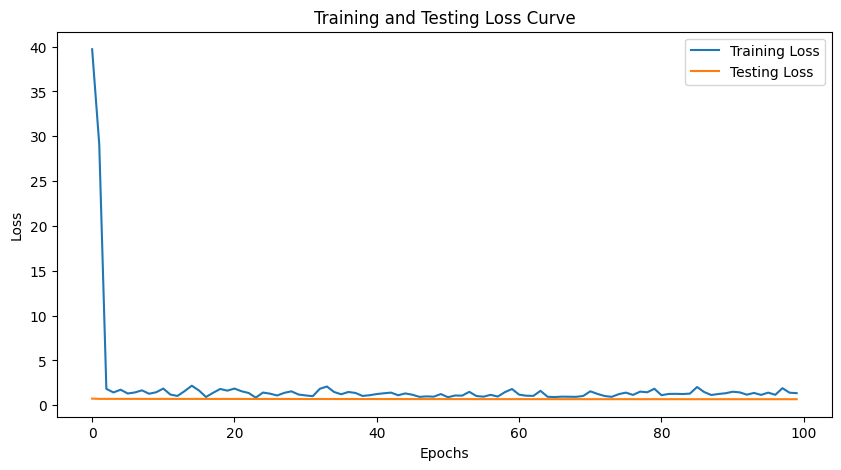

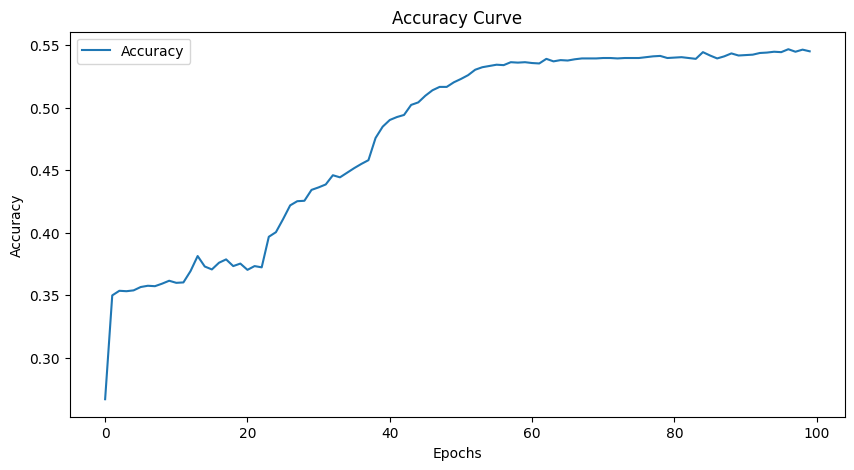

In [68]:
# Plotting the Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
#model.eval()
#with torch.no_grad():
    #test_outputs = model(torch.Tensor(X_test_scaled))
#import torch.nn.functional as F

# 计算预测概率分布
#probabilities = F.softmax(test_outputs, dim=1)
#from scipy.stats import entropy

# 计算每个数据点的熵
#entropies = [entropy(probability, base=2) for probability in probabilities.numpy()]

In [32]:
# 假设您已经计算了每个数据点的熵值并存储在了 entropies 列表中
# 将列表转换为 PyTorch 张量
#entropies_tensor = torch.tensor(entropies)

# 计算整个数据集上每个数据点的平均熵
#average_entropy = torch.mean(entropies_tensor)

# 打印整个数据集上每个数据点的平均熵
#print("整个数据集上每个数据点的平均熵：", average_entropy.item())

整个数据集上每个数据点的平均熵： 0.9956860124112181


In [40]:
all_Europe = pd.read_excel('/Users/anyingbai/Desktop/连续剧/Oxford/COPD模型/最新修改/心血管共病/机器学习模型训练/SHARE_10_18基线无共病.xlsx', index_col=0)
Europe2=all_Europe.copy(deep=True)
Europe2.dropna(axis=0, how='any', subset=None, inplace=True)
Europe2.head()
Europe2_Y = Europe2['Cardiometabolic_multi_18']
Europe2_X = Europe2.loc[:,['ADL_Disability','IADL_Disability','edu_group','Male','Married','age','household_wealth','Excessive_drink','physical_activity','smoking_present']]
X_train, X_test, y_train, y_test = train_test_split(Europe2_X,Europe2_Y, test_size = 0.40, random_state=42)

print("X_train:")
print(X_train)

print("\ny_train:")
print(y_train)

from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import softmax

batch_size = 64
train_dataset = TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values))  # Ensure y_train has shape (batch_size, 1)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 使用训练集的均值和标准差对测试集进行标准化
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)

# 设置模型结构和参数
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # 在这里定义模型结构，使用给定的最佳参数配置
        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 1), ##改为1，输出变成1维
            nn.Sigmoid()  # 在输出层使用 Sigmoid 激活函数
        )

    def forward(self, x):
        x = self.fc(x)
        return x

# 创建模型实例
torch.manual_seed(42)
model = MLP().float()

# 定义优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.functional.binary_cross_entropy # 使用functional中的binary_cross_entropy
# 设置训练的总轮次（epochs）
num_epochs = 100

# 定义训练和测试函数
def train(model, optimizer, criterion, train_loader):
    model.train()
    train_losses = []
    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        batch_data = batch_data.float()
        outputs = model(batch_data)
        loss = criterion(outputs.squeeze(), batch_labels.float())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return np.mean(train_losses)

def test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(42)
        val_outputs = model(torch.Tensor(X_test_scaled))
        val_loss = criterion(val_outputs.squeeze(), torch.Tensor(y_test.values).float())



        # 计算预测值-改为输出一个值，大于0.5=1，小于0.5=0
        predicted = (val_outputs > 0.5).float()
        
        # 计算熵值
        probabilities = torch.nn.functional.sigmoid(val_outputs)
        epsilon = 1e-8  # 小的常数值
        probabilities = probabilities + epsilon
        entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
        
        
        # 计算平均熵值
        average_entropy = torch.mean(entropy).item()
        
        # 计算评估指标
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
        
        # 对于二分类问题，需要使用模型输出的概率值来计算 AUPRC 和 AUROC
        # 获取模型预测的概率值
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        positive_probabilities = torch.nn.functional.sigmoid(val_outputs).cpu().numpy()  # 正类的概率
        
        # 计算 AUPRC 和 AUROC
        auprc = average_precision_score(y_test, positive_probabilities)
        auroc = roc_auc_score(y_test, positive_probabilities)
        
        return val_loss.item(), precision, recall, f1, auprc, auroc, average_entropy

# 在每个 epoch 中更新测试函数的调用并存储评估指标
test_metrics = {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auprc': [], 'auroc': [], 'entropy': []}
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    test_loss, precision, recall, f1, auprc, auroc, avg_entropy = test(model, X_test_scaled, y_test)  
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    # 存储评估指标
    test_metrics['loss'].append(test_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)
    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}, Precision: {precision}, Recall: {recall}, F1: {f1}, AUPRC: {auprc}, AUROC: {auroc}, Avg Entropy: {avg_entropy}')
    
# 输出最终评估指标
final_metrics = {
    'Average_Test_Loss': np.mean(test_metrics['loss']),
    'Average_Precision': np.mean(test_metrics['precision']),
    'Average_Recall': np.mean(test_metrics['recall']),
    'Average_F1': np.mean(test_metrics['f1']),
    'Average_AUPRC': np.mean(test_metrics['auprc']),
    'Average_AUROC': np.mean(test_metrics['auroc']),
    'Average_entropy': np.mean(test_metrics['entropy'])
    
}
print("Final Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

X_train:
              ADL_Disability  IADL_Disability  edu_group  Male  Married  age  \
mergeid                                                                        
F1-025272-01             0.0              0.0        2.0     1      0.0   71   
CZ-879064-02             0.0              0.0        0.0     1      0.0   65   
ES-986496-01             0.0              0.0        1.0     2      1.0   55   
EE-489735-01             0.0              0.0        1.0     1      1.0   51   
EE-828935-01             0.0              0.0        2.0     1      1.0   67   
...                      ...              ...        ...   ...      ...  ...   
EE-773325-01             0.0              0.0        1.0     1      1.0   75   
EE-519142-02             0.0              0.0        1.0     2      1.0   58   
EE-614257-02             0.0              0.0        2.0     1      1.0   65   
AT-814518-01             0.0              0.0        1.0     2      1.0   63   
F1-567878-05             0.0   

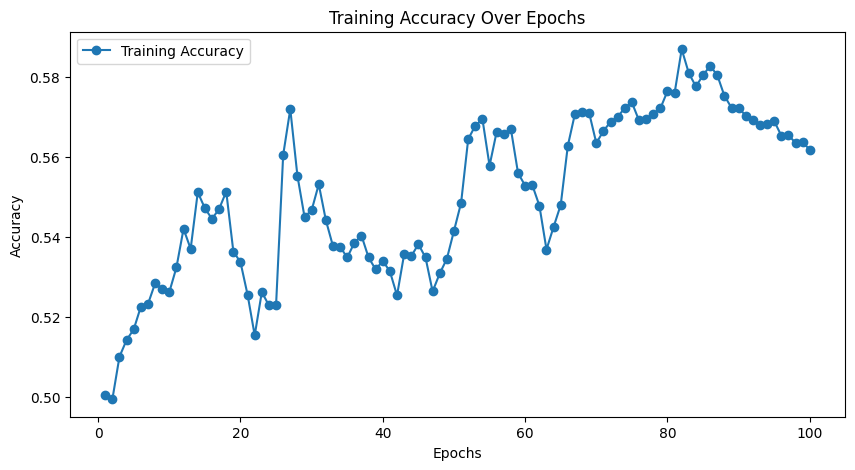

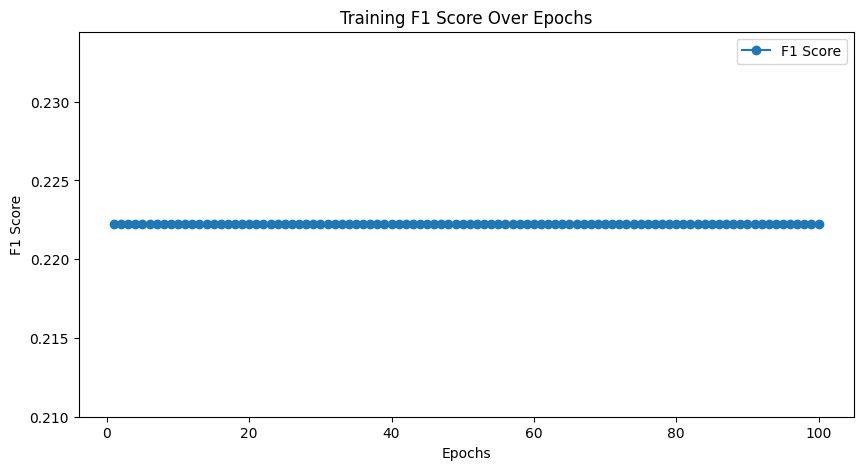

In [41]:
# Lists to store training metrics for each epoch
train_losses = []
train_accuracies = []  # Added for storing training accuracies
f1_scores = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)

    # Calculate accuracy on training data
    model.eval()
    with torch.no_grad():
        train_outputs = model(torch.Tensor(X_train_scaled))
        train_predicted = (train_outputs > 0.5).float()

    # Ensure y_train is a NumPy array for accurate comparison
    y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train

    train_accuracy = (train_predicted.cpu().numpy().squeeze() == y_train_array).mean()
    train_accuracies.append(train_accuracy)

    # Append values to lists
    train_losses.append(train_loss)
    f1_scores.append(f1)

    # 存储评估指标
    test_metrics['loss'].append(train_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)

# Plot learning curves
epochs = range(1, num_epochs + 1)

# Plotting Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, label='F1 Score', marker='o')
plt.title('Training F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# ... (Remaining code remains unchanged)

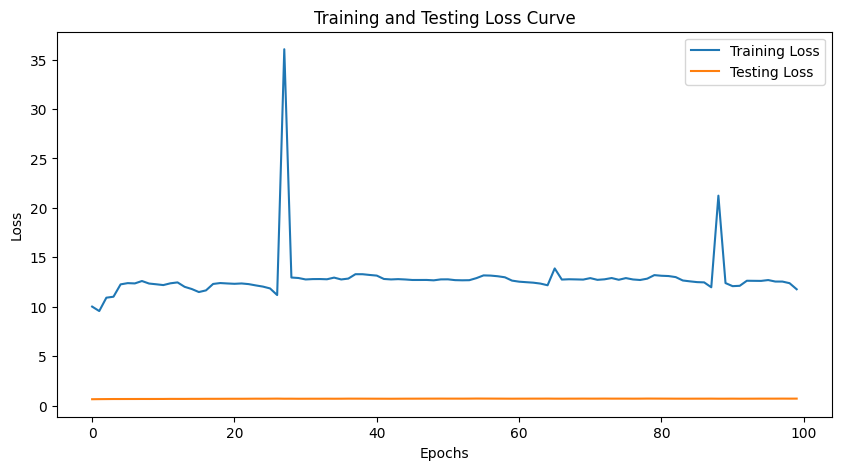

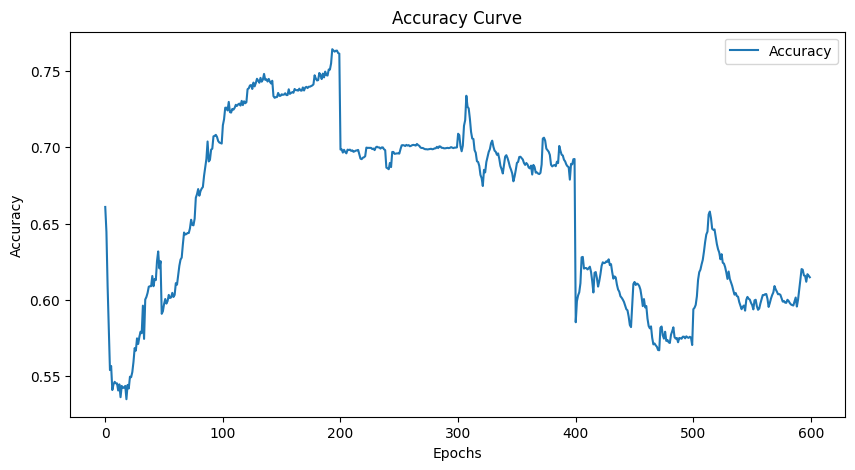

In [15]:
# Plotting the Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
#引入美国数据作外部验证
all_US = pd.read_excel('/Users/anyingbai/Desktop/连续剧/Oxford/COPD模型/最新修改/心血管共病/机器学习模型训练/HRS_10_18基线无共病.xlsx', index_col=0)
US2=all_US.copy(deep=True)
US2.dropna(axis=0, how='any', subset=None, inplace=True)
US2.head()

US2_Y = US2['Cardiometabolic_multi_18']
US2_X = US2.loc[:,['ADL_Disability','IADL_Disability','edu_group','Male','Married','age','household_wealth','Excessive_drink','physical_activity','smoking_present']]

# 使用训练集的均值和标准差对测试集进行标准化
scaler = StandardScaler()
US2_X_scaled = scaler.fit_transform(US2_X)


def test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(42)
        val_outputs = model(torch.Tensor(US2_X_scaled))
        val_loss = criterion(val_outputs.squeeze(), torch.Tensor(US2_Y.values).float())



        # 计算预测值-改为输出一个值，大于0.5=1，小于0.5=0
        predicted = (val_outputs > 0.5).float()
        
        # 计算熵值
        probabilities = torch.nn.functional.sigmoid(val_outputs)
        epsilon = 1e-8  # 小的常数值
        probabilities = probabilities + epsilon
        entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
        
        
        # 计算平均熵值
        average_entropy = torch.mean(entropy).item()
        
        # 计算评估指标
        precision = precision_score(US2_Y, predicted)
        recall = recall_score(US2_Y, predicted)
        f1 = f1_score(US2_Y, predicted)
        
        # 对于二分类问题，需要使用模型输出的概率值来计算 AUPRC 和 AUROC
        # 获取模型预测的概率值
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        positive_probabilities = torch.nn.functional.sigmoid(val_outputs).cpu().numpy()  # 正类的概率
        
        # 计算 AUPRC 和 AUROC
        auprc = average_precision_score(US2_Y, positive_probabilities)
        auroc = roc_auc_score(US2_Y, positive_probabilities)
        
        return val_loss.item(), precision, recall, f1, auprc, auroc, average_entropy

# 在每个 epoch 中更新测试函数的调用并存储评估指标
test_metrics = {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auprc': [], 'auroc': [], 'entropy': []}
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    test_loss, precision, recall, f1, auprc, auroc, avg_entropy = test(model, US2_X_scaled, US2_Y)  
    # Calculate accuracy
    with torch.no_grad():
        torch.manual_seed(42)
        val_outputs = model(torch.Tensor(US2_X_scaled))
        predicted = (val_outputs > 0.5).float()
    # Ensure y_test is a NumPy array for accurate comparison
    US2_Y_array = US2_Y.values if isinstance(US2_Y, pd.Series) else US2_Y

    accuracy = (predicted.cpu().numpy().squeeze() == US2_Y_array).mean()

    # Append values to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    # 存储评估指标
    test_metrics['loss'].append(test_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)
    
# 输出最终评估指标
final_metrics = {
    'Average_Test_Loss': np.mean(test_metrics['loss']),
    'Average_Precision': np.mean(test_metrics['precision']),
    'Average_Recall': np.mean(test_metrics['recall']),
    'Average_F1': np.mean(test_metrics['f1']),
    'Average_AUPRC': np.mean(test_metrics['auprc']),
    'Average_AUROC': np.mean(test_metrics['auroc']),
    'Average_entropy': np.mean(test_metrics['entropy'])
    
}
print("Final Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

Final Evaluation Metrics:
Average_Test_Loss: 0.7548910039663315
Average_Precision: 0.2261730598071485
Average_Recall: 0.6343672416572627
Average_F1: 0.33342270844590055
Average_AUPRC: 0.2486117876306945
Average_AUROC: 0.5949918114349722
Average_entropy: 0.4208131128549576


In [12]:
#引入中国数据作外部验证
all_Chinese = pd.read_excel('/Users/anyingbai/Desktop/连续剧/Oxford/COPD模型/最新修改/心血管共病/机器学习模型训练/CHARLS_10_18基线无共病.xlsx', index_col=0)
Chinese2=all_Chinese.copy(deep=True)
Chinese2.dropna(axis=0, how='any', subset=None, inplace=True)
Chinese2.head()
Chinese2.isnull().sum()
Chinese2_Y = Chinese2['Cardiometabolic_multi_18']
Chinese2_X = Chinese2.loc[:,['ADL_Disability','IADL_Disability','edu_group','Male','Married','age','household_wealth','Excessive_drink','physical_activity','smoking_present']]

# 使用训练集的均值和标准差对测试集进行标准化
scaler = StandardScaler()
Chinese2_X_scaled = scaler.fit_transform(Chinese2_X)


def test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(42)
        val_outputs = model(torch.Tensor(Chinese2_X_scaled))
        val_loss = criterion(val_outputs.squeeze(), torch.Tensor(Chinese2_Y.values).float())



        # 计算预测值-改为输出一个值，大于0.5=1，小于0.5=0
        predicted = (val_outputs > 0.5).float()
        
        # 计算熵值
        probabilities = torch.nn.functional.sigmoid(val_outputs)
        epsilon = 1e-8  # 小的常数值
        probabilities = probabilities + epsilon
        entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
        
        
        # 计算平均熵值
        average_entropy = torch.mean(entropy).item()
        
        # 计算评估指标
        precision = precision_score(Chinese2_Y, predicted)
        recall = recall_score(Chinese2_Y, predicted)
        f1 = f1_score(Chinese2_Y, predicted)
        
        # 对于二分类问题，需要使用模型输出的概率值来计算 AUPRC 和 AUROC
        # 获取模型预测的概率值
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        positive_probabilities = torch.nn.functional.sigmoid(val_outputs).cpu().numpy()  # 正类的概率
        
        # 计算 AUPRC 和 AUROC
        auprc = average_precision_score(Chinese2_Y, positive_probabilities)
        auroc = roc_auc_score(Chinese2_Y, positive_probabilities)
        
        return val_loss.item(), precision, recall, f1, auprc, auroc, average_entropy

# 在每个 epoch 中更新测试函数的调用并存储评估指标
test_metrics = {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auprc': [], 'auroc': [], 'entropy': []}
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    test_loss, precision, recall, f1, auprc, auroc, avg_entropy = test(model, Chinese2_X_scaled, Chinese2_Y)  
    # Calculate accuracy
    with torch.no_grad():
        torch.manual_seed(42)
        val_outputs = model(torch.Tensor(Chinese2_X_scaled))
        predicted = (val_outputs > 0.5).float()
    # Ensure y_test is a NumPy array for accurate comparison
    Chinese2_Y_array = Chinese2_Y.values if isinstance(Chinese2_Y, pd.Series) else Chinese2_Y

    accuracy = (predicted.cpu().numpy().squeeze() == Chinese2_Y_array).mean()

    # Append values to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    # 存储评估指标
    test_metrics['loss'].append(test_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)
    
# 输出最终评估指标
final_metrics = {
    'Average_Test_Loss': np.mean(test_metrics['loss']),
    'Average_Precision': np.mean(test_metrics['precision']),
    'Average_Recall': np.mean(test_metrics['recall']),
    'Average_F1': np.mean(test_metrics['f1']),
    'Average_AUPRC': np.mean(test_metrics['auprc']),
    'Average_AUROC': np.mean(test_metrics['auroc']),
    'Average_entropy': np.mean(test_metrics['entropy'])
    
}
print("Final Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

Final Evaluation Metrics:
Average_Test_Loss: 0.746053410768509
Average_Precision: 0.14385950676557008
Average_Recall: 0.6694111675126905
Average_F1: 0.23682012713534933
Average_AUPRC: 0.16294259233143799
Average_AUROC: 0.5501987662927851
Average_entropy: 0.42116700023412706


In [36]:
#引入美国数据

In [27]:
all_US = pd.read_excel('/Users/anyingbai/Desktop/连续剧/Oxford/COPD模型/最新修改/心血管共病/机器学习模型训练/HRS_10_18基线无共病.xlsx', index_col=0)
US2=all_US.copy(deep=True)
US2.dropna(axis=0, how='any', subset=None, inplace=True)
US2.head()

,Male,edu_group,Married,age,smoking_present,physical_activity,household_wealth,ADL_Disability,IADL_Disability,Excessive_drink,Cardiometabolic_multi_18
ID,,,,,,,,,,,
10004040,0,1.0,1.0,64,0.0,1.0,103050000,0,0,1,0
10004040,0,1.0,1.0,64,0.0,1.0,103050000,0,0,1,0
10004040,0,1.0,1.0,64,0.0,1.0,103050000,0,0,1,0
10004040,0,1.0,1.0,64,0.0,1.0,103050000,0,0,1,0
10004040,0,1.0,1.0,64,0.0,1.0,103050000,0,0,1,0


In [32]:
US2_Y = US2['Cardiometabolic_multi_18']
US2_X = US2.loc[:,['ADL_Disability','IADL_Disability','edu_group','Male','Married','age','household_wealth','Excessive_drink','physical_activity','smoking_present']]
X_train, X_test, y_train, y_test = train_test_split(US2_X, US2_Y, test_size = 0.40, random_state=42)

In [35]:
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import softmax

batch_size = 64
train_dataset = TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values))  # Ensure y_train has shape (batch_size, 1)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 使用训练集的均值和标准差对测试集进行标准化
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)

# 设置模型结构和参数
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # 在这里定义模型结构，使用给定的最佳参数配置
        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 1), ##改为1，输出变成1维
            nn.Sigmoid()  # 在输出层使用 Sigmoid 激活函数
        )

    def forward(self, x):
        x = self.fc(x)
        return x

# 创建模型实例
model = MLP().float()

# 定义优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.functional.binary_cross_entropy # 使用functional中的binary_cross_entropy
# 设置训练的总轮次（epochs）
num_epochs = 100

# 定义训练和测试函数
def train(model, optimizer, criterion, train_loader):
    model.train()
    train_losses = []
    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        batch_data = batch_data.float()
        outputs = model(batch_data)
        loss = criterion(outputs.squeeze(), batch_labels.float())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return np.mean(train_losses)

def test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        val_outputs = model(torch.Tensor(X_test_scaled))
        val_loss = criterion(val_outputs.squeeze(), torch.Tensor(y_test.values).float())



        # 计算预测值-改为输出一个值，大于0.5=1，小于0.5=0
        predicted = (val_outputs > 0.5).float()
        
        # 计算熵值
        probabilities = torch.nn.functional.sigmoid(val_outputs)
        epsilon = 1e-8  # 小的常数值
        probabilities = probabilities + epsilon
        entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
    
        
        # 计算平均熵值
        average_entropy = torch.mean(entropy).item()
        
        # 计算评估指标
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
        
        # 对于二分类问题，需要使用模型输出的概率值来计算 AUPRC 和 AUROC
        # 获取模型预测的概率值
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        positive_probabilities = torch.nn.functional.sigmoid(val_outputs).cpu().numpy()  # 正类的概率
        
        # 计算 AUPRC 和 AUROC
        auprc = average_precision_score(y_test, positive_probabilities)
        auroc = roc_auc_score(y_test, positive_probabilities)
        
        return val_loss.item(), precision, recall, f1, auprc, auroc, average_entropy

# 在每个 epoch 中更新测试函数的调用并存储评估指标
test_metrics = {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auprc': [], 'auroc': [], 'entropy': []}
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    test_loss, precision, recall, f1, auprc, auroc, avg_entropy = test(model, X_test_scaled, y_test)  
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    # 存储评估指标
    test_metrics['loss'].append(test_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)
    
# 输出最终评估指标
final_metrics = {
    'Average_Test_Loss': np.mean(test_metrics['loss']),
    'Average_Precision': np.mean(test_metrics['precision']),
    'Average_Recall': np.mean(test_metrics['recall']),
    'Average_F1': np.mean(test_metrics['f1']),
    'Average_AUPRC': np.mean(test_metrics['auprc']),
    'Average_AUROC': np.mean(test_metrics['auroc']),
    'Average_entropy': np.mean(test_metrics['entropy'])
    
}
print("Final Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

Final Evaluation Metrics:
Average_Test_Loss: 0.6631895124912262
Average_Precision: 0.2542819019445
Average_Recall: 0.460277108433735
Average_F1: 0.3275473889860723
Average_AUPRC: 0.2467096811905953
Average_AUROC: 0.5955324853068494
Average_entropy: 0.4296903073787689


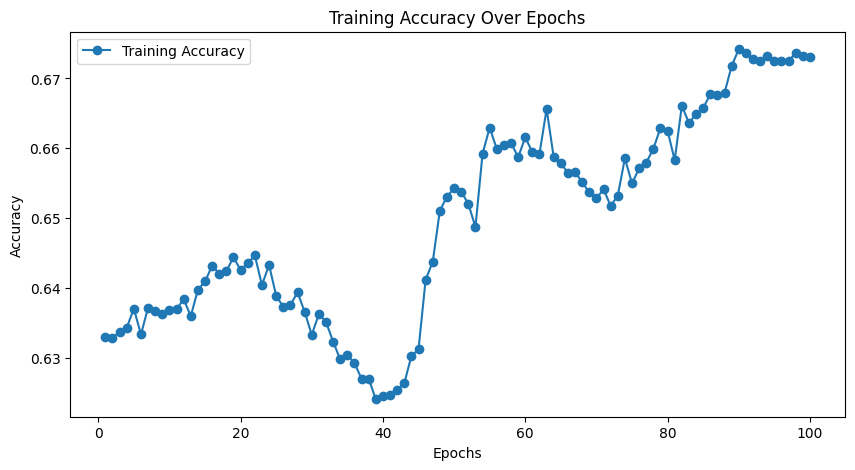

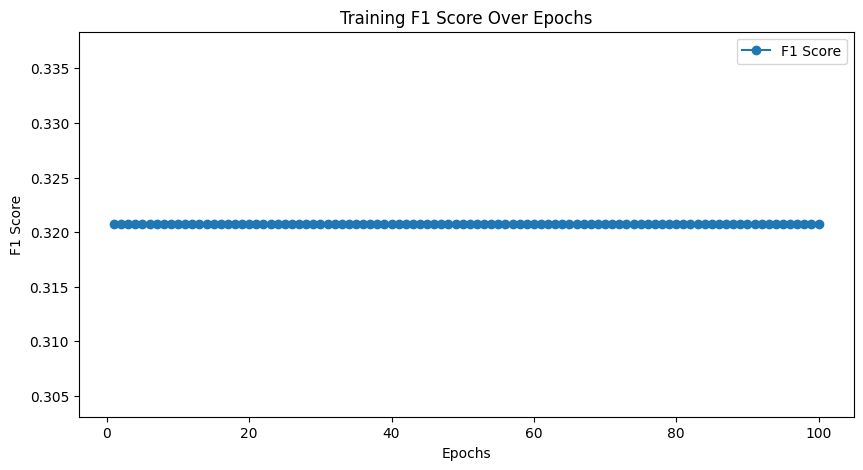

In [36]:
# Lists to store training metrics for each epoch
train_losses = []
train_accuracies = []  # Added for storing training accuracies
f1_scores = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)

    # Calculate accuracy on training data
    model.eval()
    with torch.no_grad():
        train_outputs = model(torch.Tensor(X_train_scaled))
        train_predicted = (train_outputs > 0.5).float()

    # Ensure y_train is a NumPy array for accurate comparison
    y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train

    train_accuracy = (train_predicted.cpu().numpy().squeeze() == y_train_array).mean()
    train_accuracies.append(train_accuracy)

    # Append values to lists
    train_losses.append(train_loss)
    f1_scores.append(f1)

    # 存储评估指标
    test_metrics['loss'].append(train_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)

# Plot learning curves
epochs = range(1, num_epochs + 1)

# Plotting Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, label='F1 Score', marker='o')
plt.title('Training F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# ... (Remaining code remains unchanged)

In [18]:
#引入欧洲数据作外部验证
all_Europe = pd.read_excel('/Users/anyingbai/Desktop/连续剧/Oxford/COPD模型/最新修改/心血管共病/机器学习模型训练/SHARE_10_18基线无共病.xlsx', index_col=0)
Europe2=all_Europe.copy(deep=True)
Europe2.dropna(axis=0, how='any', subset=None, inplace=True)
Europe2.head()
Europe2_Y = Europe2['Cardiometabolic_multi_18']
Europe2_X = Europe2.loc[:,['ADL_Disability','IADL_Disability','edu_group','Male','Married','age','household_wealth','Excessive_drink','physical_activity','smoking_present']]


# 使用训练集的均值和标准差对测试集进行标准化
scaler = StandardScaler()
Europe2_X_scaled = scaler.fit_transform(Europe2_X)


def test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(42)
        val_outputs = model(torch.Tensor(Europe2_X_scaled))
        val_loss = criterion(val_outputs.squeeze(), torch.Tensor(Europe2_Y.values).float())



        # 计算预测值-改为输出一个值，大于0.5=1，小于0.5=0
        predicted = (val_outputs > 0.5).float()
        
        # 计算熵值
        probabilities = torch.nn.functional.sigmoid(val_outputs)
        epsilon = 1e-8  # 小的常数值
        probabilities = probabilities + epsilon
        entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
        
        
        # 计算平均熵值
        average_entropy = torch.mean(entropy).item()
        
        # 计算评估指标
        precision = precision_score(Europe2_Y, predicted)
        recall = recall_score(Europe2_Y, predicted)
        f1 = f1_score(Europe2_Y, predicted)
        
        # 对于二分类问题，需要使用模型输出的概率值来计算 AUPRC 和 AUROC
        # 获取模型预测的概率值
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        positive_probabilities = torch.nn.functional.sigmoid(val_outputs).cpu().numpy()  # 正类的概率
        
        # 计算 AUPRC 和 AUROC
        auprc = average_precision_score(Europe2_Y, positive_probabilities)
        auroc = roc_auc_score(Europe2_Y, positive_probabilities)
        
        return val_loss.item(), precision, recall, f1, auprc, auroc, average_entropy

# 在每个 epoch 中更新测试函数的调用并存储评估指标
test_metrics = {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auprc': [], 'auroc': [], 'entropy': []}
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    test_loss, precision, recall, f1, auprc, auroc, avg_entropy = test(model, Europe2_X_scaled, Europe2_Y)  
    # Calculate accuracy
    with torch.no_grad():
        val_outputs = model(torch.Tensor(Europe2_X_scaled))
        predicted = (val_outputs > 0.5).float()
    # Ensure y_test is a NumPy array for accurate comparison
    Europe2_Y_array = Europe2_Y.values if isinstance(Europe2_Y, pd.Series) else Europe2_Y

    accuracy = (predicted.cpu().numpy().squeeze() == Europe2_Y_array).mean()

    # Append values to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    # 存储评估指标
    test_metrics['loss'].append(test_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)
    
# 输出最终评估指标
final_metrics = {
    'Average_Test_Loss': np.mean(test_metrics['loss']),
    'Average_Precision': np.mean(test_metrics['precision']),
    'Average_Recall': np.mean(test_metrics['recall']),
    'Average_F1': np.mean(test_metrics['f1']),
    'Average_AUPRC': np.mean(test_metrics['auprc']),
    'Average_AUROC': np.mean(test_metrics['auroc']),
    'Average_entropy': np.mean(test_metrics['entropy'])
    
}
print("Final Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

Final Evaluation Metrics:
Average_Test_Loss: 0.6139985638856887
Average_Precision: 0.20967580549081838
Average_Recall: 0.2304191616766467
Average_F1: 0.21825965498643907
Average_AUPRC: 0.17515872951343595
Average_AUROC: 0.5823509977281098
Average_entropy: 0.4375549155473709


In [21]:
#引入中国数据作外部验证
all_Chinese = pd.read_excel('/Users/anyingbai/Desktop/连续剧/Oxford/COPD模型/最新修改/心血管共病/机器学习模型训练/CHARLS_10_18基线无共病.xlsx', index_col=0)
Chinese2=all_Chinese.copy(deep=True)
Chinese2.dropna(axis=0, how='any', subset=None, inplace=True)
Chinese2.head()
Chinese2.isnull().sum()
Chinese2_Y = Chinese2['Cardiometabolic_multi_18']
Chinese2_X = Chinese2.loc[:,['ADL_Disability','IADL_Disability','edu_group','Male','Married','age','household_wealth','Excessive_drink','physical_activity','smoking_present']]

# 使用训练集的均值和标准差对测试集进行标准化
scaler = StandardScaler()
Chinese2_X_scaled = scaler.fit_transform(Chinese2_X)


def test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(42)
        val_outputs = model(torch.Tensor(Chinese2_X_scaled))
        val_loss = criterion(val_outputs.squeeze(), torch.Tensor(Chinese2_Y.values).float())



        # 计算预测值-改为输出一个值，大于0.5=1，小于0.5=0
        predicted = (val_outputs > 0.5).float()
        
        # 计算熵值
        probabilities = torch.nn.functional.sigmoid(val_outputs)
        epsilon = 1e-8  # 小的常数值
        probabilities = probabilities + epsilon
        entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
        
        
        # 计算平均熵值
        average_entropy = torch.mean(entropy).item()
        
        # 计算评估指标
        precision = precision_score(Chinese2_Y, predicted)
        recall = recall_score(Chinese2_Y, predicted)
        f1 = f1_score(Chinese2_Y, predicted)
        
        # 对于二分类问题，需要使用模型输出的概率值来计算 AUPRC 和 AUROC
        # 获取模型预测的概率值
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        positive_probabilities = torch.nn.functional.sigmoid(val_outputs).cpu().numpy()  # 正类的概率
        
        # 计算 AUPRC 和 AUROC
        auprc = average_precision_score(Chinese2_Y, positive_probabilities)
        auroc = roc_auc_score(Chinese2_Y, positive_probabilities)
        
        return val_loss.item(), precision, recall, f1, auprc, auroc, average_entropy

# 在每个 epoch 中更新测试函数的调用并存储评估指标
test_metrics = {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auprc': [], 'auroc': [], 'entropy': []}
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    test_loss, precision, recall, f1, auprc, auroc, avg_entropy = test(model, Chinese2_X_scaled, Chinese2_Y)  
    # Calculate accuracy
    with torch.no_grad():
        torch.manual_seed(42)
        val_outputs = model(torch.Tensor(Chinese2_X_scaled))
        predicted = (val_outputs > 0.5).float()
    # Ensure y_test is a NumPy array for accurate comparison
    Chinese2_Y_array = Chinese2_Y.values if isinstance(Chinese2_Y, pd.Series) else Chinese2_Y

    accuracy = (predicted.cpu().numpy().squeeze() == Chinese2_Y_array).mean()

    # Append values to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    # 存储评估指标
    test_metrics['loss'].append(test_loss)
    test_metrics['precision'].append(precision)
    test_metrics['recall'].append(recall)
    test_metrics['f1'].append(f1)
    test_metrics['auprc'].append(auprc)
    test_metrics['auroc'].append(auroc)
    test_metrics['entropy'].append(avg_entropy)
    
# 输出最终评估指标
final_metrics = {
    'Average_Test_Loss': np.mean(test_metrics['loss']),
    'Average_Precision': np.mean(test_metrics['precision']),
    'Average_Recall': np.mean(test_metrics['recall']),
    'Average_F1': np.mean(test_metrics['f1']),
    'Average_AUPRC': np.mean(test_metrics['auprc']),
    'Average_AUROC': np.mean(test_metrics['auroc']),
    'Average_entropy': np.mean(test_metrics['entropy'])
    
}
print("Final Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

Final Evaluation Metrics:
Average_Test_Loss: 0.5960173678398132
Average_Precision: 0.20596681966265634
Average_Recall: 0.2350456852791878
Average_F1: 0.21952420463383265
Average_AUPRC: 0.16992379396339097
Average_AUROC: 0.5698660205884498
Average_entropy: 0.4406992366909981
